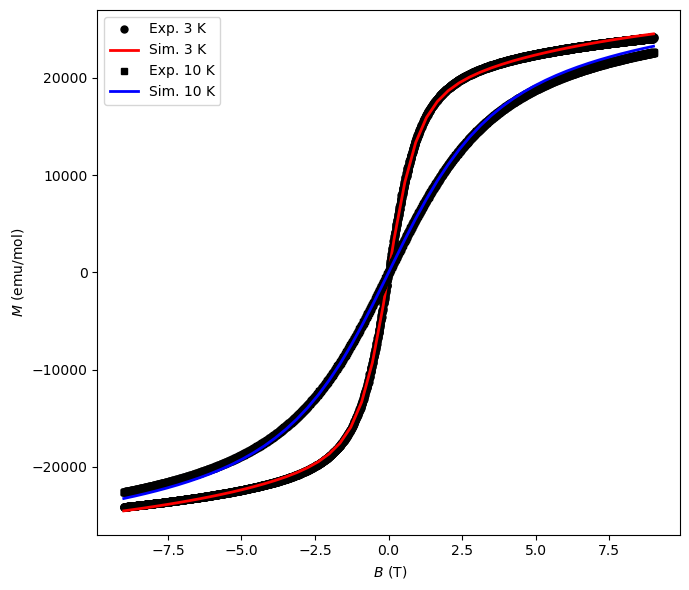

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import N_A


h   = 6.62607015e-27
c   = 2.99792458e10
kB  = 1.380649e-16
muB = 9.2740100783e-21

CMINV_TO_ERGMOL = h * c * N_A


df_3K  = pd.read_csv("M16M2-MH3.csv")
df_10K = pd.read_csv("M16M3-MH10.csv")

# Conversão emu/g para emu/mol
M_exp_3K  = df_3K["M (emu/g)"] * 780.26
M_exp_10K = df_10K["M (emu/g)"] * 780.26

B_exp_3K  = np.array(df_3K["Magnetic Field (Oe)"])
B_exp_10K = np.array(df_10K["Magnetic Field (Oe)"])


# 3 PARÂMETROS DO MODELO
S = 3/2

J_cm = -5.96
D_cm = 62.00
E_cm = 15.99

gx, gy, gz = 2.5, 2.5, 2.45

CHI_DIA = -1e-4

# OPERADORES DE SPIN
def get_spin_operators(S):
    dim = int(2*S + 1)
    m = np.arange(S, -S-1, -1)

    Sz = np.diag(m)
    Sp = np.zeros((dim, dim))
    Sm = np.zeros((dim, dim))

    for i in range(dim-1):
        mi = m[i]
        coef = np.sqrt(S*(S+1) - mi*(mi-1))
        Sp[i, i+1] = coef
        Sm[i+1, i] = coef

    Sx = (Sp + Sm) / 2
    Sy = (Sp - Sm) / (2j)

    return Sx, Sy, Sz

Sx, Sy, Sz = get_spin_operators(S)
I = np.eye(int(2*S + 1))

# Operadores do dímero
S1x, S2x = np.kron(Sx, I), np.kron(I, Sx)
S1y, S2y = np.kron(Sy, I), np.kron(I, Sy)
S1z, S2z = np.kron(Sz, I), np.kron(I, Sz)


#  HAMILTONIANO
def get_hamiltonian(Bx, By, Bz):

    J = J_cm * CMINV_TO_ERGMOL
    D = D_cm * CMINV_TO_ERGMOL
    E = E_cm * CMINV_TO_ERGMOL

    # Troca
    H_J = J * (S1x@S2x + S1y@S2y + S1z@S2z)

    # ZFS
    S_scalar = S*(S+1)/3
    I_dimer = np.eye(S1z.shape[0])

    ZFS_axial    = (Sz@Sz - S_scalar * I)
    ZFS_rhombic  = (Sx@Sx - Sy@Sy)

    H_D = D * (np.kron(ZFS_axial, I) + np.kron(I, ZFS_axial))
    H_E = E * (np.kron(ZFS_rhombic, I) + np.kron(I, ZFS_rhombic))

    # Zeeman
    H_Z = muB * N_A * (
        gx * Bx * (S1x + S2x) +
        gy * By * (S1y + S2y) +
        gz * Bz * (S1z + S2z)
    )

    return H_J + H_D + H_E + H_Z


# MÉDIA DE PÓ – ESFERA DE FIBONACCI
def get_fibonacci_sphere(n):
    pts = []
    phi = np.pi * (3 - np.sqrt(5))
    for i in range(n):
        z = 1 - 2*i/(n-1)
        r = np.sqrt(1 - z*z)
        theta = phi * i
        pts.append((r*np.cos(theta), r*np.sin(theta), z))
    return np.array(pts)

def magnetization_powder(B, T, n_points=600):

    beta = 1/(kB * T * N_A)
    M = 0.0
    pts = get_fibonacci_sphere(n_points)

    for ux, uy, uz in pts:

        Bx, By, Bz = B*ux, B*uy, B*uz

        dB = 0.1
        H0 = get_hamiltonian(Bx, By, Bz)
        H1 = get_hamiltonian(Bx*(1+dB/B), By*(1+dB/B), Bz*(1+dB/B))

        E0 = np.linalg.eigvalsh(H0)
        E1 = np.linalg.eigvalsh(H1)

        mu = -(E1 - E0)/dB

        Erel = E0 - E0.min()
        w = np.exp(-beta * Erel)
        Z = w.sum()

        M += np.sum(mu * w) / Z

    return M / n_points

# SIMULAÇÕES – 3 K e 10 K
B_sim_3K  = np.linspace(B_exp_3K.min(),  B_exp_3K.max(),  50)
B_sim_10K = np.linspace(B_exp_10K.min(), B_exp_10K.max(), 50)

M_sim_3K = np.array([magnetization_powder(B, 3.0)  for B in B_sim_3K])  + CHI_DIA * B_sim_3K
M_sim_10K = np.array([magnetization_powder(B, 10.0) for B in B_sim_10K]) + CHI_DIA * B_sim_10K

# PLOT – EXPERIMENTAL + SIMULAÇÃO
plt.figure(figsize=(7,6))

plt.plot(B_exp_3K/10000,  M_exp_3K,  'ko', ms=5, label='Exp. 3 K')
plt.plot(B_sim_3K/10000,  M_sim_3K,  'r-', lw=2, label='Sim. 3 K')

plt.plot(B_exp_10K/10000, M_exp_10K, 'ks', ms=5, label='Exp. 10 K')
plt.plot(B_sim_10K/10000, M_sim_10K, 'b-', lw=2, label='Sim. 10 K')

plt.xlabel(r' $B$ (T)')
plt.ylabel(r'$M$ (emu/mol)')
#plt.title('Magnetização – Curvas a 3 K e 10 K')
#plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
J_cm*h*c/kB

-8.575110189923445

In [5]:
import pandas as pd
import numpy as np

# ============================
# 3 K
# ============================
df_3K_out = pd.DataFrame({
    "B_exp (T)":  B_exp_3K / 10000,   # Tesla
    "M_exp (emu/mol)":    M_exp_3K,
})

df_3K_sim_out = pd.DataFrame({
    "B_sim (T)":  B_sim_3K / 10000,   # Tesla
    "M_sim (emu/mol)":    M_sim_3K,
})

df_3K_out.to_csv("Magnetizacao_Exp_3K.csv", index=False)
df_3K_sim_out.to_csv("Magnetizacao_Sim_3K.csv", index=False)

# ============================
# 10 K
# ============================
df_10K_out = pd.DataFrame({
    "B_exp (T)":  B_exp_10K / 10000,  # Tesla
    "M_exp (emu/mol)":    M_exp_10K,
})

df_10K_sim_out = pd.DataFrame({
    "B_sim (T)":  B_sim_10K / 10000,  # Tesla
    "M_sim (emu/mol)":    M_sim_10K,
})

df_10K_out.to_csv("Magnetizacao_Exp_10K.csv", index=False)
df_10K_sim_out.to_csv("Magnetizacao_Sim_10K.csv", index=False)


In [2]:
# Ativa LaTeX e configura as fontes
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'cm'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

In [4]:
from scipy.interpolate import interp1d

def rmsd(y_exp, y_sim):
    return np.sqrt(np.mean((y_exp - y_sim)**2))

def nrmsd(y_exp, y_sim):
    return rmsd(y_exp, y_sim) / (y_exp.max() - y_exp.min())


In [5]:
# INTERPOLAÇÃO 
interp_3K = interp1d(B_sim_3K, M_sim_3K, kind='linear', fill_value="extrapolate")
interp_10K = interp1d(B_sim_10K, M_sim_10K, kind='linear', fill_value="extrapolate")

M_sim_3K_interp  = interp_3K(B_exp_3K)
M_sim_10K_interp = interp_10K(B_exp_10K)


In [6]:

# ERROS DOS AJUSTES
RMSD_3K  = rmsd(M_exp_3K,  M_sim_3K_interp)
NRMSD_3K = nrmsd(M_exp_3K, M_sim_3K_interp)

RMSD_10K  = rmsd(M_exp_10K,  M_sim_10K_interp)
NRMSD_10K = nrmsd(M_exp_10K, M_sim_10K_interp)

print("====== ERROS DO AJUSTE ======")
print(f"3 K  -> RMSD  = {RMSD_3K:.4e} emu/mol")
print(f"3 K  -> NRMSD = {NRMSD_3K:.4e}")

print(f"10 K -> RMSD  = {RMSD_10K:.4e} emu/mol")
print(f"10 K -> NRMSD = {NRMSD_10K:.4e}")


====== ERROS DO AJUSTE ======
3 K  -> RMSD  = 3.3304e+02 emu/mol
3 K  -> NRMSD = 6.8925e-03
10 K -> RMSD  = 2.2942e+02 emu/mol
10 K -> NRMSD = 5.0726e-03


In [7]:
def chi2_reduced(y_exp, y_sim, n_params):
    
    residuals = y_exp - y_sim
    sigma = np.std(residuals)

    N = len(y_exp)
    chi2 = np.sum((residuals / sigma)**2)

    return chi2 / (N - n_params)


In [8]:

n_params = 4  

chi2_3K  = chi2_reduced(M_exp_3K,  M_sim_3K_interp,  n_params)
chi2_10K = chi2_reduced(M_exp_10K, M_sim_10K_interp, n_params)

print("====== CHI² REDUZIDO ======")
print(f"3 K  -> chi²_red = {chi2_3K:.3f}")
print(f"10 K -> chi²_red = {chi2_10K:.3f}")


====== CHI² REDUZIDO ======
3 K  -> chi²_red = 1.032
10 K -> chi²_red = 1.022
